# 📓 Notebook - Teori & Praktik Bab 3: Klasifikasi

Selamat datang di notebook panduan untuk Bab 3! Bab ini membahas tugas Machine Learning yang paling umum: **Klasifikasi**, yaitu memprediksi kategori atau kelas dari sebuah data.

Kita akan menggunakan dataset **MNIST** (gambar digit tulisan tangan) sebagai contoh utama.

## 1. Dataset MNIST

**Teori :**
Dataset MNIST adalah "hello world"-nya klasifikasi gambar. Ini berisi 70.000 gambar grayscale kecil (28x28 piksel) dari digit 0 hingga 9 yang ditulis tangan. Setiap gambar memiliki label berupa digit yang direpresentasikannya.

Scikit-Learn menyediakan fungsi untuk mengunduh dataset populer seperti MNIST.

Kunci dataset MNIST: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])
Shape X: (70000, 784)
Shape y: (70000,)


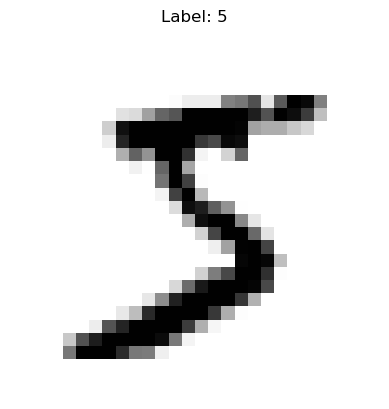

In [1]:
# Impor library dan unduh dataset MNIST
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
print("Kunci dataset MNIST:", mnist.keys())

# Pisahkan fitur (X) dan label (y)
X, y = mnist["data"], mnist["target"]

print("Shape X:", X.shape) # 70000 gambar, 784 fitur (28x28 piksel)
print("Shape y:", y.shape) # 70000 label

# Konversi label dari string ke integer
y = y.astype(np.uint8)

# Tampilkan salah satu digit
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.title(f"Label: {y[0]}")
plt.show()

### Membagi Data Latih dan Data Uji
Dataset MNIST sudah terbagi: 60.000 gambar pertama untuk latihan, 10.000 terakhir untuk pengujian.

In [2]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
print(f"Ukuran data latih: {len(X_train)}")
print(f"Ukuran data uji: {len(X_test)}")

Ukuran data latih: 60000
Ukuran data uji: 10000


## 2. Melatih Pengklasifikasi Biner (Binary Classifier)

**Teori :**
Mari kita sederhanakan masalahnya: membuat model yang hanya bisa mendeteksi satu digit, misalnya angka 5. Ini disebut **pengklasifikasi biner**, karena hanya membedakan dua kelas: "angka 5" dan "bukan angka 5".

Kita akan menggunakan `SGDClassifier` dari Scikit-Learn, yang efisien untuk dataset besar.

In [3]:
from sklearn.linear_model import SGDClassifier

# Buat label target untuk deteksi angka 5
y_train_5 = (y_train == 5) # True jika 5, False jika bukan
y_test_5 = (y_test == 5)

# Inisialisasi dan latih model SGDClassifier
# random_state untuk hasil yang bisa direproduksi
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Coba prediksi digit yang kita lihat tadi (angka 5)
prediksi = sgd_clf.predict([some_digit])
print(f"Prediksi untuk gambar pertama (seharusnya 5): {prediksi}")

Prediksi untuk gambar pertama (seharusnya 5): [ True]


## 3. Mengukur Performa Klasifikasi

**Teori :**
Mengevaluasi model klasifikasi lebih rumit daripada regresi. Ada banyak metrik yang bisa digunakan.

### a. Akurasi Menggunakan Cross-Validation

**Teori :**
**Akurasi** adalah rasio prediksi yang benar. Meskipun terdengar bagus, akurasi bisa menyesatkan, terutama pada *dataset* yang **tidak seimbang** (skewed dataset), yaitu ketika satu kelas jauh lebih dominan daripada kelas lain.

Mari kita lihat akurasi detektor angka 5 kita menggunakan cross-validation.

In [4]:
from sklearn.model_selection import cross_val_score

akurasi_cv = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Akurasi SGDClassifier (cross-validation 3-fold): {akurasi_cv}")
print(f"Rata-rata akurasi: {akurasi_cv.mean():.4f}")

Akurasi SGDClassifier (cross-validation 3-fold): [0.95035 0.96035 0.9604 ]
Rata-rata akurasi: 0.9570


**Teori :**
Wow, akurasi >95%! Tapi jangan senang dulu. Mari kita bandingkan dengan pengklasifikasi 'bodoh' yang selalu menebak 'bukan 5'.

In [5]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Selalu prediksi False (bukan 5)

never_5_clf = Never5Classifier()
akurasi_never5 = cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
print(f"Akurasi Never5Classifier: {akurasi_never5}")
print(f"Rata-rata akurasi 'bodoh': {akurasi_never5.mean():.4f}")

# Insight: Akurasi tinggi (>90%) hanya karena sekitar 10% data adalah angka 5.
# Ini menunjukkan akurasi bukan metrik yang baik untuk dataset tidak seimbang.

Akurasi Never5Classifier: [0.91125 0.90855 0.90915]
Rata-rata akurasi 'bodoh': 0.9096


### b. Confusion Matrix

**Teori :**
Cara yang jauh lebih baik untuk mengevaluasi performa adalah dengan melihat **Confusion Matrix**. Matriks ini menunjukkan berapa kali kelas A salah diklasifikasikan sebagai kelas B.

Baris mewakili kelas *aktual*, kolom mewakili kelas *prediksi*.

- **True Negatives (TN):** Aktual bukan 5, diprediksi bukan 5 (pojok kiri atas).
- **False Positives (FP):** Aktual bukan 5, diprediksi 5 (pojok kanan atas).
- **False Negatives (FN):** Aktual 5, diprediksi bukan 5 (pojok kiri bawah).
- **True Positives (TP):** Aktual 5, diprediksi 5 (pojok kanan bawah).

In [6]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Dapatkan prediksi untuk setiap instance di training set (menggunakan model yang tidak melihat instance tsb)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cm = confusion_matrix(y_train_5, y_train_pred)
print("Confusion Matrix:")
print(cm)

#        [Prediksi Bukan 5, Prediksi 5]
# [Aktual Bukan 5] [[TN, FP],
# [Aktual 5]       [FN, TP]]

Confusion Matrix:
[[53892   687]
 [ 1891  3530]]


### c. Precision dan Recall

**Teori :**
Dari Confusion Matrix, kita bisa menghitung metrik yang lebih informatif:

- **Precision (Presisi):** Seberapa akurat prediksi positif kita? Dari semua yang diprediksi sebagai 5, berapa yang benar-benar 5?
  Formula: `TP / (TP + FP)`

- **Recall (Sensitivity / True Positive Rate):** Berapa banyak instance positif yang berhasil dideteksi? Dari semua angka 5 yang ada, berapa yang berhasil kita prediksi sebagai 5?
  Formula: `TP / (TP + FN)`

In [8]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_5, y_train_pred)
recall = recall_score(y_train_5, y_train_pred)

print(f"Precision: {precision:.4f}") # Sekitar 83.7%
print(f"Recall: {recall:.4f}")    # Sekitar 65.1%

# Insight: Model ini hanya benar 83.7% saat menebak angka 5,
# dan hanya berhasil menemukan 65.1% dari semua angka 5 yang ada.

Precision: 0.8371
Recall: 0.6512


### d. F1 Score

**Teori :**
Seringkali kita butuh satu metrik yang menggabungkan *precision* dan *recall*. **F1 Score** adalah rata-rata harmonik dari keduanya. F1 Score tinggi jika *kedua* metrik (precision dan recall) tinggi.

Formula: `2 * (Precision * Recall) / (Precision + Recall)`

In [9]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print(f"F1 Score: {f1:.4f}") # Sekitar 73.3%

F1 Score: 0.7325


### e. Precision/Recall Trade-off

**Teori :**
Sayangnya, kita tidak bisa menaikkan *precision* dan *recall* secara bersamaan. Menaikkan salah satu biasanya akan menurunkan yang lain. Ini disebut **Precision/Recall Trade-off**.

Pengklasifikasi seperti `SGDClassifier` membuat keputusan berdasarkan *decision score*. Jika skor melebihi *threshold* (ambang batas), ia mengklasifikasikan instance sebagai positif. Menaikkan threshold akan meningkatkan precision (karena hanya prediksi yang sangat yakin yang dianggap positif) tetapi menurunkan recall (karena lebih banyak instance positif yang terlewat). Menurunkan threshold berefek sebaliknya.

Kita bisa mendapatkan *decision scores* dan memplot kurva Precision-Recall untuk melihat trade-off ini.

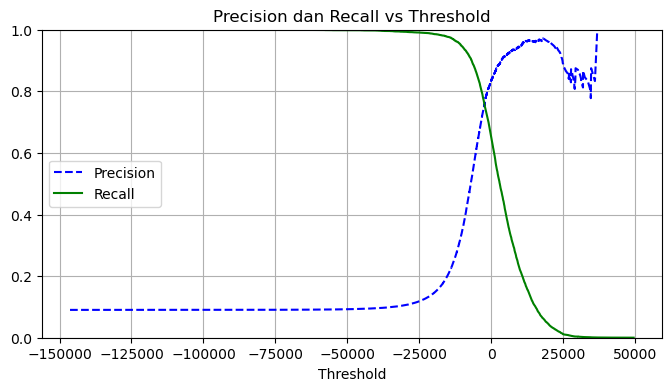

In [10]:
from sklearn.metrics import precision_recall_curve

# Dapatkan decision scores alih-alih prediksi
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

# Hitung precision, recall untuk berbagai threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot kurva
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.title("Precision dan Recall vs Threshold")
plt.show()

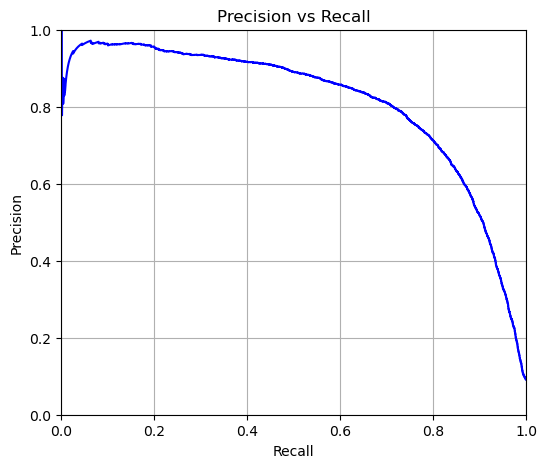

In [11]:
# Plot Precision vs Recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(6, 5))
plot_precision_vs_recall(precisions, recalls)
plt.title("Precision vs Recall")
plt.show()

# Insight: Kita bisa memilih threshold yang memberikan trade-off yang kita inginkan.
# Misalnya, jika butuh precision 90%, kita cari threshold-nya dan lihat berapa recall-nya.

### f. Kurva ROC (Receiver Operating Characteristic)

**Teori :**
Kurva ROC adalah alat umum lainnya untuk pengklasifikasi biner. Ia memplot **True Positive Rate (TPR)** alias *Recall* terhadap **False Positive Rate (FPR)**.

- **FPR:** Rasio instance negatif yang salah diklasifikasikan sebagai positif (`FP / (FP + TN)`).
- **TPR (Recall):** Rasio instance positif yang benar diklasifikasikan sebagai positif (`TP / (TP + FN)`).

Pengklasifikasi yang baik akan menjauh dari garis diagonal (pengklasifikasi acak) menuju pojok kiri atas. **Area Under the Curve (AUC)** dari kurva ROC adalah metrik ringkasan yang bagus: AUC=1 untuk pengklasifikasi sempurna, AUC=0.5 untuk pengklasifikasi acak.

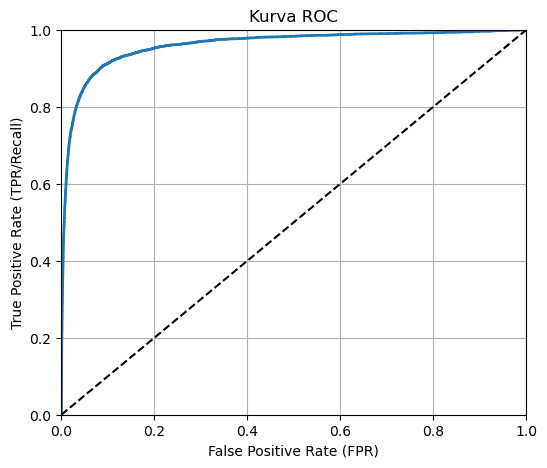

Area Under Curve (AUC): 0.9605


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Garis diagonal (acak)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR/Recall)')
    plt.grid(True)

plt.figure(figsize=(6, 5))
plot_roc_curve(fpr, tpr, "SGD")
plt.title("Kurva ROC")
plt.show()

# Hitung AUC
auc = roc_auc_score(y_train_5, y_scores)
print(f"Area Under Curve (AUC): {auc:.4f}") # Sekitar 0.96

## 4. Klasifikasi Multikelas (Multiclass Classification)

**Teori :**
Bagaimana jika kita punya lebih dari dua kelas, seperti pada MNIST (0-9)? Ini disebut **Klasifikasi Multikelas**.

Beberapa algoritma (seperti `SGDClassifier`, `RandomForestClassifier`, `Naive Bayes`) bisa menangani multikelas secara langsung. Algoritma lain (seperti `LogisticRegression`, `SVC`) pada dasarnya adalah biner.

Untuk menggunakan pengklasifikasi biner pada tugas multikelas, ada dua strategi utama:
- **One-vs-the-Rest (OvR) / One-vs-All (OvA):** Melatih satu pengklasifikasi biner untuk setiap kelas (misalnya, 0 vs bukan-0, 1 vs bukan-1, dst.). Saat prediksi, pilih kelas yang pengklasifikasinya memberikan skor tertinggi.
- **One-vs-One (OvO):** Melatih satu pengklasifikasi biner untuk setiap *pasangan* kelas (misalnya, 0 vs 1, 0 vs 2, ..., 1 vs 2, dst.). Jika ada N kelas, butuh N*(N-1)/2 pengklasifikasi. Saat prediksi, jalankan semua pengklasifikasi dan pilih kelas yang memenangkan 'duel' terbanyak.

Scikit-Learn secara otomatis mendeteksi jika Anda menggunakan algoritma biner untuk tugas multikelas dan akan memilih OvR atau OvO (biasanya OvR, kecuali untuk SVM yang menggunakan OvO karena lebih efisien untuk SVM).

In [13]:
# SGDClassifier bisa menangani multikelas secara langsung
sgd_clf.fit(X_train, y_train) # Gunakan y_train asli (0-9), bukan y_train_5

prediksi_multikelas = sgd_clf.predict([some_digit])
print(f"Prediksi SGD untuk gambar pertama (seharusnya 5): {prediksi_multikelas}")

# Melihat skor untuk setiap kelas
some_digit_scores = sgd_clf.decision_function([some_digit])
print("\nSkor untuk setiap kelas:")
print(np.round(some_digit_scores, 2))
print(f"Kelas dengan skor tertinggi: {np.argmax(some_digit_scores)}")

Prediksi SGD untuk gambar pertama (seharusnya 5): [3]

Skor untuk setiap kelas:
[[-31893.03 -34419.69  -9530.64   1823.73 -22320.15  -1385.8  -26188.91
  -16147.51  -4604.35 -12050.77]]
Kelas dengan skor tertinggi: 3


## 5. Analisis Kesalahan (Error Analysis)

**Teori :**
Setelah melatih model multikelas, penting untuk menganalisis jenis kesalahan yang dibuatnya. Confusion matrix adalah alat yang sangat baik untuk ini.

Kita bisa memvisualisasikan confusion matrix untuk melihat pola kesalahan. Misalnya, apakah model sering salah mengklasifikasikan 3 sebagai 5, atau 8 sebagai 9?

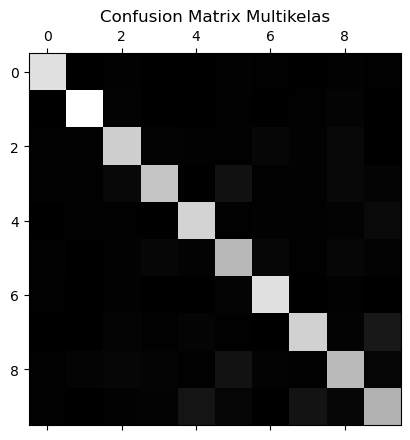

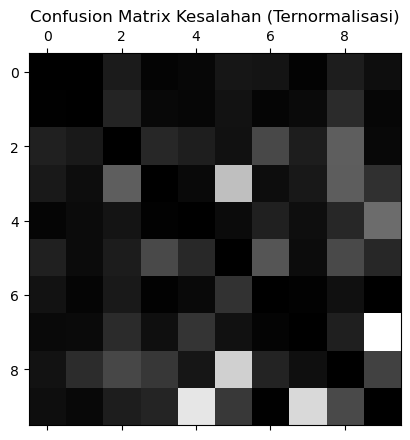

In [14]:
# Dapatkan prediksi multikelas menggunakan cross-validation
y_train_pred_multi = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

# Hitung confusion matrix
conf_mx_multi = confusion_matrix(y_train, y_train_pred_multi)

# Visualisasikan confusion matrix
plt.matshow(conf_mx_multi, cmap=plt.cm.gray)
plt.title("Confusion Matrix Multikelas")
plt.show()

# Fokus pada kesalahan: bagi setiap nilai dengan jumlah gambar di kelas aktual
# dan isi diagonal utama (prediksi benar) dengan nol
row_sums = conf_mx_multi.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx_multi / row_sums
np.fill_diagonal(norm_conf_mx, 0)

plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Confusion Matrix Kesalahan (Ternormalisasi)")
plt.show()

# Insight: Kolom yang terang menunjukkan kelas yang sering salah diprediksi.
# Baris yang terang menunjukkan kelas aktual yang sering salah diklasifikasikan.
# Misalnya, angka 3 dan 5 sering tertukar.

## 6. Klasifikasi Multilabel (Multilabel Classification)

**Teori :**
Bagaimana jika setiap instance bisa memiliki *lebih dari satu* label secara bersamaan? Contoh: mengenali beberapa orang dalam satu foto.

Ini disebut **Klasifikasi Multilabel**. Tidak semua algoritma klasifikasi mendukung ini. `KNeighborsClassifier` adalah salah satu yang bisa.

Evaluasinya bisa dilakukan dengan menghitung metrik (misalnya, F1 score) untuk setiap label secara terpisah, lalu dirata-ratakan.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

# Contoh: Buat dua label untuk setiap digit
# Label 1: Apakah digit >= 7?
# Label 2: Apakah digit ganjil?
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

# Latih KNeighborsClassifier (mendukung multilabel)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

# Prediksi untuk gambar pertama (angka 5)
prediksi_multilabel = knn_clf.predict([some_digit])
print(f"Prediksi multilabel untuk angka 5: {prediksi_multilabel}")
print("(Benar: [False, True] -> tidak besar, ganjil)")

# Evaluasi (misalnya, rata-rata F1 score)
# Perhatian: cross_val_predict tidak mendukung multilabel secara langsung
# Cara evaluasi yang umum adalah rata-rata F1 score per label
# y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) # Ini akan error
# f1 = f1_score(y_multilabel, y_train_knn_pred, average="macro")
# print(f"Rata-rata F1 Score (macro): {f1:.4f}")

Prediksi multilabel untuk angka 5: [[False  True]]
(Benar: [False, True] -> tidak besar, ganjil)


## 7. Klasifikasi Multioutput (Multioutput Classification)

**Teori :**
Ini adalah generalisasi dari klasifikasi multilabel di mana setiap label bisa berupa *multikelas* (bukan hanya biner).

Contoh: Sistem penghilang noise pada gambar MNIST. Inputnya adalah gambar digit dengan noise, outputnya adalah gambar digit yang bersih. Setiap piksel pada output adalah sebuah 'label' multikelas (nilai intensitas piksel dari 0-255).

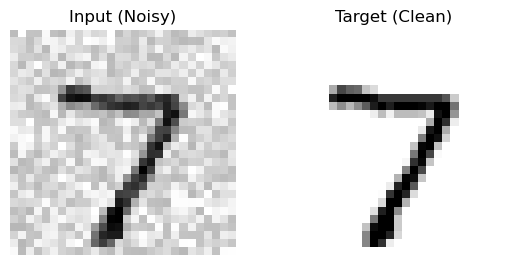

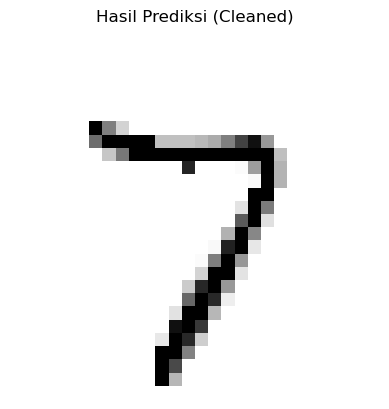

In [16]:
# Tambahkan noise ke gambar MNIST
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise_train
X_test_mod = X_test + noise_test
y_train_mod = X_train # Targetnya adalah gambar asli
y_test_mod = X_test

# Tampilkan contoh gambar dengan noise dan targetnya
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.title("Input (Noisy)")
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.title("Target (Clean)")
plt.show()

# Latih model KNN untuk membersihkan noise
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plt.figure()
plot_digit(clean_digit)
plt.title("Hasil Prediksi (Cleaned)")
plt.show()

## Kesimpulan Bab 3

Bab ini mencakup dasar-dasar klasifikasi, mulai dari metrik evaluasi yang penting (akurasi, precision, recall, F1, ROC AUC) hingga strategi untuk menangani masalah multikelas, multilabel, dan multioutput. Analisis kesalahan menggunakan confusion matrix juga merupakan langkah krusial untuk meningkatkan performa model.